<a href="https://colab.research.google.com/github/leehgkor/lhg/blob/main/(6)_%EA%B0%90%EC%A0%95%EB%B6%84%EC%84%9D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# step1: 필요한 라이브러리 및 모델 설치

!pip install torch transformers kobert-transformers koreanize-matplotlib konlpy

import os
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from konlpy.tag import Okt
import koreanize_matplotlib
import matplotlib.pyplot as plt
import numpy as np

# KoBERT 모델 로드

class KoBERTSentimentAnalyzer:
    def __init__(self, model_name='monologg/kobert'):
        self.tokenizer = BertTokenizer.from_pretrained(model_name)
        self.model = BertForSequenceClassification.from_pretrained(
            model_name,
            num_labels=7  # 감정 분류 클래스 수
        )
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model.to(self.device)

    def analyze_sentiment(self, text):
        """입력 텍스트의 감정을 분석"""
        inputs = self.tokenizer(
            text,
            return_tensors="pt",
            truncation=True,
            padding=True,
            max_length=128
        ).to(self.device)
        outputs = self.model(**inputs)
        probs = torch.nn.functional.softmax(outputs.logits, dim=-1).detach().cpu().numpy()[0]
        return probs

# KoBERT 기반 감정 분석기 초기화
kobert_analyzer = KoBERTSentimentAnalyzer()

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'KoBertTokenizer'. 
The class this function is called from is 'BertTokenizer'.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at monologg/kobert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# step2: 텍스트 파일 읽기

# 파일 경로
file_path = "/content/이문열___우리들의_일그러진_영웅___86쪽.txt"

# 파일 읽기
with open(file_path, "r", encoding="utf-8") as file:
    text = file.read()


In [ ]:
# step3: 텍스트 전처리(구간 분리, 형태소 분석)

# 구간 분리
def split_text_into_segments(text, num_segments):
    """텍스트를 구간별로 나누기"""
    lines = text.splitlines()
    lines = [line.strip() for line in lines if line.strip()]  # 빈 줄 제거
    segment_size = len(lines) // num_segments
    segments = [" ".join(lines[i * segment_size: (i + 1) * segment_size]) for i in range(num_segments)]
    return segments

# 형태소 분석 및 전처리
okt = Okt()

def preprocess_segment(segment):
    """형태소 분석 및 명사 추출"""
    return " ".join(okt.nouns(segment))

# 실행
num_segments = 10  # 원하는 구간 수
segments = split_text_into_segments(text, num_segments)
processed_segments = [preprocess_segment(segment) for segment in segments]


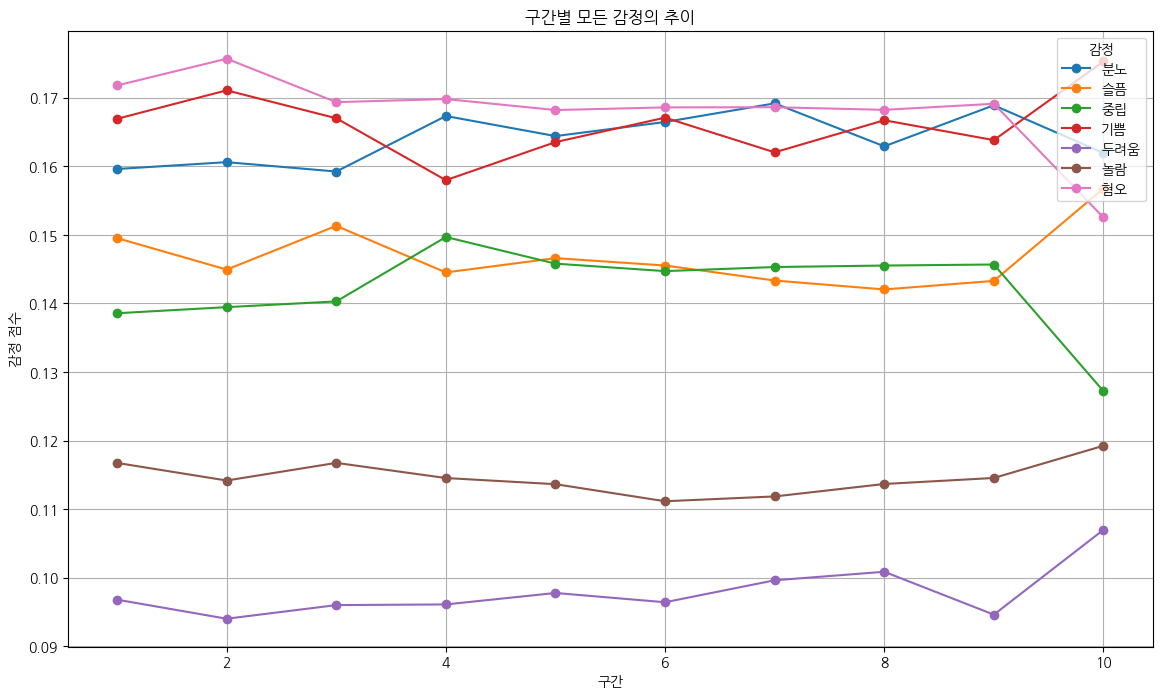

구간 1: 주요 감정 = 혐오, 점수 = 0.1718
구간 2: 주요 감정 = 혐오, 점수 = 0.1757
구간 3: 주요 감정 = 혐오, 점수 = 0.1694
구간 4: 주요 감정 = 혐오, 점수 = 0.1698
구간 5: 주요 감정 = 혐오, 점수 = 0.1682
구간 6: 주요 감정 = 혐오, 점수 = 0.1686
구간 7: 주요 감정 = 분노, 점수 = 0.1692
구간 8: 주요 감정 = 혐오, 점수 = 0.1683
구간 9: 주요 감정 = 혐오, 점수 = 0.1691
구간 10: 주요 감정 = 기쁨, 점수 = 0.1753


In [ ]:
# step4: 감정 분석 및 결과 출력

emotion_labels = ["분노", "슬픔", "중립", "기쁨", "두려움", "놀람", "혐오"]
all_emotion_scores = []

for segment in processed_segments:
    probs = kobert_analyzer.analyze_sentiment(segment)  # KoBERT 감정 분석 실행
    all_emotion_scores.append(probs)

# numpy 배열로 변환 (구간 × 감정 형식)
all_emotion_scores = np.array(all_emotion_scores)

# 감정 분석 시각화
plt.figure(figsize=(14, 8))
for i, emotion in enumerate(emotion_labels):
    plt.plot(range(1, num_segments + 1), all_emotion_scores[:, i], label=emotion, marker='o')

plt.xlabel("구간")
plt.ylabel("감정 점수")
plt.title("구간별 모든 감정의 추이")
plt.legend(title="감정", loc="upper right")
plt.grid(True)
plt.show()

# 구간별 주요 감정 출력
for i, probs in enumerate(all_emotion_scores):
    max_idx = np.argmax(probs)
    print(f"구간 {i + 1}: 주요 감정 = {emotion_labels[max_idx]}, 점수 = {probs[max_idx]:.4f}")
